## Hoverboard Controller Update

We have updated the firmware, the new firmare includes a PID controller.

The hoverboard firmware expects a value between -2000 to 2000 to set the speed of a wheel. Values between -49 and 49 are now accepted.

We can set the PID parameters through the API, the values are integer values

The C code for the PID controller is as follows:

```C
float last_error = 0;
float Kp = -1; // Proportial
float Ki = -1; // Integral
float Kd = -1; // Differential
float Iterm = 0; // Remember Integral of error
const float windup_guard = 1000;

int16_t updatePID(const float desired_val, const float measured_val, const float dt)
{
        float error;
        float delta_error;
        float Dterm;

        if (Kp == -1 || Ki == -1 || Kp == -1)
        {
                // PID values not initialized
                return 0;
        }
        error = desired_val - measured_val;
        delta_error = error - last_error;
        Iterm += error * dt;

        // Prevent I from getting too large
        if (Iterm < - windup_guard)
        {
                Iterm = - windup_guard;
        }
        else if (Iterm > windup_guard)
        {
                Iterm = windup_guard;
        }
        Dterm = 0;
        if (dt > 0)
        {
                Dterm = delta_error / dt;
        }
        // Remember stuff for next calculation
        last_error = error;
        // Compute actual PWM output
        return (int16_t) (Kp*error + Ki*Iterm + Kd*Dterm);
}
```

And it is called in bldc.c after the speed is calculated:

```C
    if(loopCounter < 16000 && inc == 0) // Number of loops with no increment gives time
    {
        loopCounter++;
    }
    else
    {
        if (inc != last_inc)
        {
            last_inc = inc;
            // Wait for direction to be determined in next loop
        }
        else
        {
            // Set and calculate velocity
            // Update realSpeed and PWM
            realSpeed = (float)inc * 16000.0 / (float)loopCounter; // Ticks per Second
            #ifdef MASTER
            SetPWM(updatePID((float)speedM, realSpeed, (float)loopCounter / 16000.0));
            #endif
            #ifdef SLAVE
            SetPWM(updatePID((float)desiredSpeedSlave, realSpeed, (float)loopCounter / 16000.0));
            #endif
            loopCounter = 0;
        }
    }
```    
    

We will rewite the code in Python

In [16]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)


In [17]:
class PID(object):
    def __init__(self): 
        self.last_error = 0.0
        self.Kp = -1. # Proportial
        self.Ki = -1. # Integral
        self.Kd = -1. # Differential
        self.Iterm = 0. # Remember Integral of error
        self.output_guard = 1000.
 
    def updatePID(self, desired_val, measured_val, dt):
        #print("desired_val:"+str(desired_val)+" measured_val:"+str(measured_val)+" dt:"+str(dt))
        
        if (self.Kp == -1. or self.Ki == -1. or self.Kp == -1.):
            # PID values not initialized
            return 0.0
            
        error = desired_val - measured_val
        delta_error = (error - self.last_error) / dt
        self.Iterm += error * dt

        # Prevent I from getting too large
        if (self.Iterm < - self.output_guard):
            self.Iterm = - self.output_guard
        elif (self.Iterm > self.output_guard):
                self.Iterm = self.output_guard
            
        # Remember stuff for next calculation
        self.last_error = error;
        
        # Compute actual PWM output
        output = self.Kp * error + self.Ki * self.Iterm + self.Kd * delta_error
        
        return clamp(output,-self.output_guard,self.output_guard) # it is better to clamp the ouput inside the PID

We simulate the hoverboard

We calculate the real speed based on a limited acceleration

We also have to deal with a variable dt (work in progress)

In [18]:
import random
class Hoverboard(object):
    def __init__(self, dt):
        self.dt = dt
        self.present_rpm = 0

    def get_speed(self, PWM):
        # wheel mass
        m = 3.0 # kg
        # wheel radius
        r = 0.165 * 0.5
        # wheel inertia
        I = 0.5 * m * r ** 2

        # hub motor max RPM (no load)
        rpm_max = 600. # RPM
        # hub motor max torque
        torque_max = 3. # Nm
        
        # hub motor frictions
        kf = 0.0036 # Nm per RPM (arbitrary constant)
        tf_static = 0.1 # Nm (arbitrary constant)
        
        # compute max torque at current speed
        present_torque_max = torque_max * (1.0 - abs(self.present_rpm) / rpm_max )
        
        # compute torque according PWM (max PWM = 1000.0)
        present_pwm = clamp(PWM,-1000.,1000.)
        present_torque = present_torque_max * present_pwm / 1000.0
        
        # apply friction at start up
        if self.present_rpm >= 0.0 and present_torque > 0:
            present_torque = max(0.,present_torque-tf_static)
        elif self.present_rpm <= 0.0 and present_torque < 0:
            present_torque = min(0.,present_torque+tf_static)
            
        # apply friction over speed
        friction_torque = self.present_rpm * kf
        if self.present_rpm > 0. and present_torque >= 0:
            present_torque = max(0.,present_torque-friction_torque)
        elif self.present_rpm < 0. and present_torque <= 0:
            present_torque = min(0.,present_torque-friction_torque)
        
        # compute angular acceleration : depends on torque and inertia
        acc = present_torque / I # rad/s²
        
        # compute speed from angular acceleration
        delta_speed = acc * dt # rad/s
        
        # convert to RPM
        self.present_rpm += delta_speed / (2.0 * np.pi) * 60.0
        
        return self.present_rpm, self.dt

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

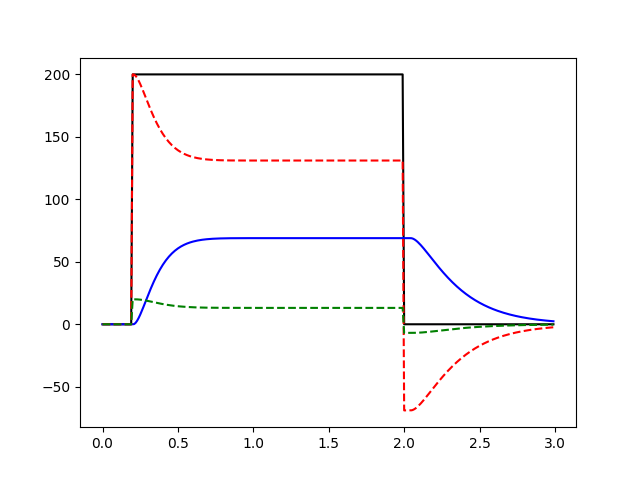

In [20]:
# time base
dt = 0.010 # 100Hz is enough
t_max = 3.0
x = np.arange(0, t_max, dt)

# speed profil (without acceleration/deceleration)
v_setpoint = np.zeros_like(x)
v_setpoint[20:200] = 200.0 # RPM hi speed test (forward)

# motor/wheel physical model
hb = Hoverboard(dt/10.) # we will run the hub motor model 10x faster than controller and PID

# PID
# input : speed error
# ouput : PWM value
pid = PID()
pid.Kp = 1.0 # Proportial
pid.Ki = 0.0 # Integral
pid.Kd = 0.0 # Differential

# simulation
v_actual = np.zeros_like(x, dtype=float)
pwm = np.zeros_like(x, dtype=float)
v_error = np.zeros_like(x, dtype=float)

# variable to add latency into speed feedback
speed_feedback = 0. # RPM
pwm_setpoint = 0. # -1000 +1000

for i in range(0, len(v_setpoint)):
    
    # simulate the hub motor wheel faster than controller
    for j in range(10):
        # compute actual RPM 
        v_actual[i], dt = hb.get_speed(pwm_setpoint)
    
    # simulate feedback latency
    speed_feedback = 0.8 * speed_feedback + v_actual[i] * 0.2
    
    # update PWM setpoint using PID and speed setpoint and feedback
    pwm[i] = pid.updatePID(v_setpoint[i], speed_feedback, dt)
    
    pwm_setpoint = 0.8 * pwm_setpoint + pwm[i] * 0.2
    
    v_error[i] = v_setpoint[i] - v_actual[i]
    

# plot simulation
fig, ax = plt.subplots()
ax.plot(x, v_setpoint, 'k') # black : setpoint speed 
ax.plot(x, v_actual, 'b') # blue : actual speed (simulated with basic physical model)
ax.plot(x, v_error, 'r--') # red, error (PID input)
ax.plot(x, pwm/10, 'g--') # green, PWM value in % (PID output)


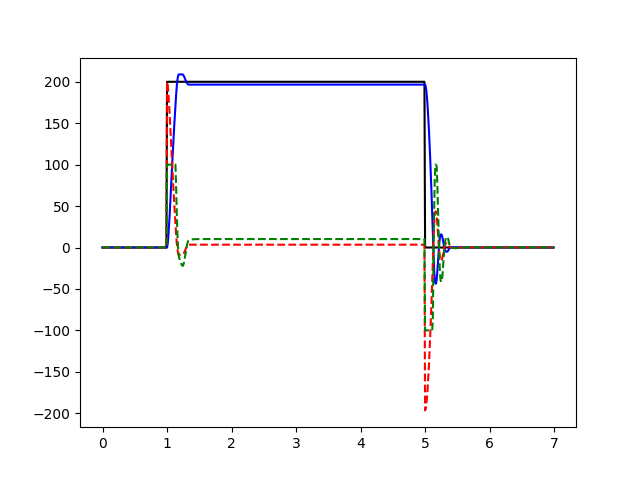

In [29]:
dt = 0.010 # 100Hz is enough
t_max = 7.0
x = np.arange(0, t_max, dt)

# speed profil (without acceleration/deceleration)
v_setpoint = np.zeros_like(x)
v_setpoint[100:100*5] = 200.0 

# motor/wheel physical model
hb = Hoverboard(dt/10.) # we will run the hub motor model 10x faster than controller and PID

# PID
# input : speed error
# ouput : PWM value
pid = PID()
pid.Kp = 30. # Proportial
pid.Ki = 0. # Integral
pid.Kd = 0.1 # Differential

# simulation
v_actual = np.zeros_like(x, dtype=float)
pwm = np.zeros_like(x, dtype=float)
v_error = np.zeros_like(x, dtype=float)

# variable to add latency into speed feedback
speed_feedback = 0. # RPM
pwm_setpoint = 0. # -1000 +1000

for i in range(0, len(v_setpoint)):
    
    # simulate the hub motor wheel faster than controller
    for j in range(10):
        # compute actual RPM 
        v_actual[i], dt = hb.get_speed(pwm_setpoint)
    
    # simulate feedback latency
    speed_feedback = 0.8 * speed_feedback + v_actual[i] * 0.2
    
    # update PWM setpoint using PID and speed setpoint and feedback
    pwm[i] = pid.updatePID(v_setpoint[i], speed_feedback, dt)
    
    pwm_setpoint = 0.8 * pwm_setpoint + pwm[i] * 0.2
    
    v_error[i] = v_setpoint[i] - v_actual[i]
    

# plot simulation
fig, ax = plt.subplots()
ax.plot(x, v_setpoint, 'k') # black : setpoint speed 
ax.plot(x, v_actual, 'b') # blue : actual speed (simulated with basic physical model)
ax.plot(x, v_error, 'r--') # red, error (PID input)
ax.plot(x, pwm/10, 'g--') # green, PWM value in % (PID output)